# Task 1: Upload and clean the data
The goal of this task is threefold:


1. we want to reduce the noise in the original raw text by removing everything that does not bring information to the language model. everything that is not exactly text: html tags, math equations, urls, etc
2. we want to prepare the corpus and make it ready for our language model by tokenizing the text. 
3. And finally, we want to remove rows with short or very long texts. As you will see, some of the entries are mostly made of large numerical tables. Entries that are too long will not be good reflection of the corpus. Entris that are too short will not bring relevant information to the language model either.



In [0]:
# We only need the following librairies

import pandas as pd
import re
import string
import csv


Let's load the dataset and shuffle it.

In [0]:
data = pd.read_csv('https://alexip-ml.s3.amazonaws.com/stackexchange_812k.csv.gz', compression='gzip').sample(frac = 1, random_state = 0).reset_index(drop = True)

In [0]:
assert data.shape == (812132, 5), "The dataset does not have the right dimensions"

And start by exploring the dataset.

In [0]:
data.head()

,post_id,parent_id,comment_id,text,category
0,291254,NaN,601672.0,The condition makes the gradient unbiased. (it...,comment
1,115372,NaN,221284.0,"Yes, that sounds fine to me.",comment
2,327356,NaN,NaN,<p>Consider gaussian variables belonging to a ...,post
3,186923,NaN,355055.0,Thanks S. Catterall. ^-^ Integrability: I knew...,comment
4,433143,NaN,NaN,Feature with very few extreme values,title


We have 3 types of text:

In [0]:
data.category.value_counts()

comment    553076
post       167304
title       91752
Name: category, dtype: int64

In [0]:
# example of titles 
for p in data[data.category == 'title'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
Transform moments of a random variable to fit the moments of another
--------------------
Which method of implementing the Brown's linear exponential smoothing is correct?
--------------------
Test goodness of fit for geometric distribution


We see that posts text have html tags and latex formatted equations.

In [0]:
for p in data[data.category == 'post'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
<p>The following come to mind:</p>

<ol>
<li><p>Decision trees/random forests</p></li>
<li><p>Support vector machines</p></li>
<li><p>K Nearest Neighbor</p></li>
</ol>

<p>You will have to play around with and tune the models to see if they work, but you might get some good results. Given that Alzheimer's is pretty rare, it might take a lot of turning and domain knowledge (e.g. in the form of kernel functions for SVMs) to do better than just always predicting 0, but hopefully these models can get you started.</p>

--------------------
<p>I use neural network to do classification. But instead of outputing one label, I want to ouput four independent labels such as [-1,1,1,-1]. Each of them is either 1 or -1, indicating a classification for a specific part of my input(image). However, I have about 3/4 -1s and 1/4 1s in my dataset, so the network tends to predict -1 everywhere, I use a simple mean square error loss now. What can I do to avoid such situation? THX!</p>



In [0]:
# And here's a sample of comments
for p in data[data.category == 'comment'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
Thanks Arun, vote up for your answer. But for my example, I never predict anything to be positive `1`, I am confused about `fpr` and `tpr`, which the last element means when `fpr` is 1, `tpr` is also 1, any thoughts?
--------------------
I think you have to Go back a step and explain how you are getting inconsistent probabilities...maybe you need to fix that first. In what sense are they estimates..
--------------------
Elvis, I am not sure about the statement that $n=3k-1$ moments should imply a unique solution. For example, if $X$ is $\mathcal{N}(\mu,\sigma)$ then $k=1$ is sufficient for any $n$. I would guess than $k>1$ would lead in this situation to many possible solutions.


# Clean up raw text
We're going to remove the following elements:
* html tags
* line returns
* urls
* latex equations
* numbers
* mentions: @someone
* digits
* most of the punctuation
* and extra spaces

For that we will use a series of simple regex patterns and the following pandas dataframe pattern:

```
pattern = r" some regex pattern"
df.text.apply(lambda t : re.sub(pattern,' ', t) )
```

Note that it's up to you to decide which elements should be removed or kept. This sequence of transformations can be modified. 

Not also that the regex patterns we use here are chosen for their simplicity. Feel free to use more precise patterns.  





In [0]:
# remove html tags
data['text'] = data.text.apply(lambda t : re.sub("<[^>]*>",' ', t) )

In [0]:
# rm line returns
data['text'] = data.text.apply(lambda t : re.sub("[\r\n]+",' ', t) )


In [0]:
# rm urls
data['text'] = data.text.apply(lambda t : re.sub("http\S+",' ', t) )


In [0]:
# rm mentions
data['text'] = data.text.apply(lambda t : re.sub("@\S+",' ', t) )


In [0]:
# rm latex
data['text'] = data.text.apply(lambda t : re.sub("\$[^>]*\$",' ', t) )


In [0]:
# rm digits
data['text'] = data.text.apply(lambda t : re.sub("\d+",' ', t) )


In [0]:
# rm some of the punctuation but keep ,.!? and -
remove = '"#$%&()*+/:;<=>@[\\]^_`{|}~”“'
pattern = r"[{}]".format(remove)
data['text'] = data.text.apply(lambda t : re.sub(pattern,' ', t) )


In [0]:
# rm multiple spaces
data['text'] = data.text.apply(lambda t : re.sub("\s\s+",' ', t) )


In [0]:
# finally remove trailing spaces with strip()
data['text'] = data.text.apply(lambda t : t.strip() )


Let's check out the resulting text for the different types:

In [0]:
# titles should not be changed
for p in data[data.category == 'title'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
Two small non-normally distributed samples and one simple question
--------------------
How to test the linearity between two non normal distributed variables
--------------------
What is a correct way to test these data for significance?


In [0]:
# posts should have much less clutter
for p in data[data.category == 'post'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
Yes, that is all completely correct. Of course, if you need a value you don't know yet, you will need to feed in the already-forecasted values recursively. For instance, assume that you already know which you calculated at the previous step. In working with differenced series, it is often easier to work with differences and only convert them back to the original scale when you are all done. It makes the formulas simpler and the calculations less error-prone. Especially so once you start looking at second and higher differences.
--------------------
Is it is useful to use dummy variables even though it implies a big increase in the number of parameters? In my case, I have a training set of about observations, and I am using parameters. One of these is composed of different elements therefore whether I transform it in a dummy variable I'll have, in total, more than parameters. Is this transformation sensible?
--------------------
I find these classification systems e

In [0]:
# comments should also be less noisy
for p in data[data.category == 'comment'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
- because the hypothesis are exclusive and exhaustive
--------------------
Thank you, please have a look at Glen b's answer. Is this consistent with your answer?
--------------------
Follow-up then why is used as a non-informative distribution Jeffrey's Prior This is information, IMHO... the knowledge that and are more likely than . .


# Tokenize

Let's tokenize the text. 
This will allow us to count the number of tokens of each text and subsequently remove test that are too long or too short.
You can use other librairies to tokenize the text (spacy for instance) or other tokenizer. Here we use the [WordPunctTokenizer](https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.regexp.WordPunctTokenizer) from NLTK.

And we create a new columns called tokens




In [0]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
data['tokens'] = data.text.apply(lambda t : tokenizer.tokenize(t.lower())) 


Let's now count the tokens in each piece of text


In [0]:
data['n_tokens'] = data.tokens.apply(len)

In [0]:
data.n_tokens.describe()

count    812132.000000
mean         60.074186
std          99.416031
min           0.000000
25%          16.000000
50%          35.000000
75%          70.000000
max       10874.000000
Name: n_tokens, dtype: float64

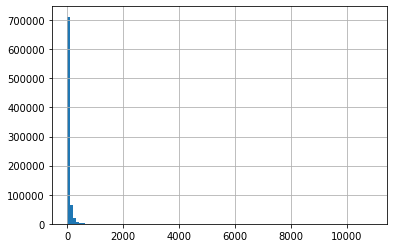

In [0]:
data.n_tokens.hist(bins = 100)

We see that we have some extremely long texts. Let's look at the largest one

In [0]:
# this one has a very long series of "L,"
print(data[data.n_tokens > 10000].text.values[0])

My sample includes subjects, of which belong to group L , while the other to group L please see data below . I used GLM for a binary outcome to test for group differences in background variables - summary pre lt - glm L g a m p e, family binomial logit , data df ...yielding significant differences for of them g, a, m, p, and e . So I modeled these background variables as covariates when testing for an association between my predictor, chr and my outcome rsk , in each one of the groups L , L , again using GLM for binary outcome summary fit lt - glm rsk chr g a m p e, family binomial logit , data df which df L , The results showed that a significant association does exist for L but not for L . I would appreciate your help in how to test whether significance non-significance can be attributed to the group condition? . Or in other words, is it true that for subjects L , a significant correlation is evident, while for L ' it's absent. Thanks for responders! Uri structure list L c , , , , , 

We can see that most of the longest texts are composed of tables with limited semantic value. 
We will remove rows that have more than an arbitrary number of tokens (let's say 5000) as well as rows that have too few tokens.

In [0]:
data = data[(data.n_tokens > 4) & (data.n_tokens < 5000)].reset_index(drop = True)
data.shape

(789649, 7)

In [0]:
data.category.value_counts()

comment    540587
post       165377
title       83685
Name: category, dtype: int64

# Export data
We could export the dataframe as such using a pickle file format. 

However if we want to keep the original csv format it's going to be easier if we transform the list of tokens into a space separated string.

On retrieval we will only have to split the string to get back the list of tokens.

In [0]:
data['tokens'] = data.tokens.apply(lambda tk : ' '.join(tk))
data.tokens.head()

0    the condition makes the gradient unbiased . it...
1                       yes , that sounds fine to me .
2    consider gaussian variables belonging to a gau...
3    thanks s . catterall . - integrability i knew ...
4                 feature with very few extreme values
Name: tokens, dtype: object

And finally let's export the dataframe into a csv file.
We will use that csv file as the new cleaned up and filtered out dataset to build our language model in task 2.


In [0]:
data.to_csv('stackexchange_812k.tokenized.csv', quoting = csv.QUOTE_ALL, index = False)


# Conclusion
Removing or adding steps to this first text processing task will allow us to test different approaches in our language model building process.

For instance we can decide not to remove the latex formatted mathematical equation and see if the language model is able to create grammatically valid equations. 

We could also implement a step to handle contractions (i'm, let's, ...) and see if that improves the quality of the generated text

Finally we could also decide to work on the vocabulary and filter out typos or non-English unknown words using named entity recognition to tag specific tokens.


